In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
import multiprocess as mp
import copy

vast


## Configuration

In [2]:
DO_CHECK = False

# User inputs
N_TREES_LIST = [x.item() for x in np.arange(82,189,2)]  # List of N_trees to run
N_PROCESSES = 2 if kgs.env=='local' else 3  # Maximum concurrent processes
DIAGNOSTIC_INTERVAL = 120  # Seconds between diagnostic updates
SEED_LIST = [114,115,116,117,118,119]  # Base seed for reproducibility

# Derived inputs (edit manually to customize seeds per task)
N_TREES_SEED_LIST = [(N, SEED) for N in N_TREES_LIST for SEED in SEED_LIST ]
print(N_TREES_SEED_LIST)

# Set up checkpoint/log directory
CHECKPOINT_DIR = 'rerun/' if not DO_CHECK else 'check_runs/'
os.makedirs(kgs.temp_dir + CHECKPOINT_DIR, exist_ok=True)
print(f"Using checkpoint directory: {CHECKPOINT_DIR}")

# Create base runner configuration
import pack_ga3
import pack_runner

base_runner = pack_ga3.baseline_symmetry_180_tesselated()
#base_runner.n_generations = 500
# base_runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Perfect dimer'
# base_runner.ga.ga_base.initializer.ref_sol_axis1_offset = None
# base_runner.ga.ga_base.initializer.ref_sol_axis2_offset = 'set!'
# base_runner.ga.stop_check_generations_scale = 10

base_runner.ga.do_legalize = True
base_runner.use_atomic_save = True  # Enable atomic saves for multiprocess safety

base_runner.diagnostic_plot = False  # Disabled in subprocess
if DO_CHECK:
    base_runner.n_generations = 1000

[(82, 114), (82, 115), (82, 116), (82, 117), (82, 118), (82, 119), (84, 114), (84, 115), (84, 116), (84, 117), (84, 118), (84, 119), (86, 114), (86, 115), (86, 116), (86, 117), (86, 118), (86, 119), (88, 114), (88, 115), (88, 116), (88, 117), (88, 118), (88, 119), (90, 114), (90, 115), (90, 116), (90, 117), (90, 118), (90, 119), (92, 114), (92, 115), (92, 116), (92, 117), (92, 118), (92, 119), (94, 114), (94, 115), (94, 116), (94, 117), (94, 118), (94, 119), (96, 114), (96, 115), (96, 116), (96, 117), (96, 118), (96, 119), (98, 114), (98, 115), (98, 116), (98, 117), (98, 118), (98, 119), (100, 114), (100, 115), (100, 116), (100, 117), (100, 118), (100, 119), (102, 114), (102, 115), (102, 116), (102, 117), (102, 118), (102, 119), (104, 114), (104, 115), (104, 116), (104, 117), (104, 118), (104, 119), (106, 114), (106, 115), (106, 116), (106, 117), (106, 118), (106, 119), (108, 114), (108, 115), (108, 116), (108, 117), (108, 118), (108, 119), (110, 114), (110, 115), (110, 116), (110, 117

## Worker Function

In [3]:
def worker_function(N_trees, seed, base_runner_pickled, checkpoint_dir):
    """
    Worker process that runs GA for a specific N_trees.
    Runs in subprocess - output redirected to log file.
    """
    import sys
    import os
    sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
    import kaggle_support as kgs
    import copy
    import numpy as np
    
    # Redirect stdout/stderr to log file
    log_path = kgs.temp_dir + checkpoint_dir + f'ga_N{N_trees}_seed{seed}.log'
    log_file = open(log_path, 'a')
    sys.stdout = log_file
    sys.stderr = log_file
    
    print(f"\n{'='*60}")
    print(f"Starting worker: N_trees={N_trees}, seed={seed}")
    print(f"{'='*60}\n")
    
    try:
        # Unpickle base runner and configure
        import dill
        runner = dill.loads(base_runner_pickled)
        runner.seed = seed
        runner.filename = checkpoint_dir + f'ga_N{N_trees}_seed{seed}'
        old_filename = runner.filename

        skip_lists = kgs.dill_load(kgs.code_dir + 'skip_list.pickle')

        # if seed%2==0:
        #    runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.
        #    if N_trees in skip_lists[0]:
        #        raise ValueError(f"Skipping N_trees={N_trees} for seed={seed} as per skip list.")
        # else:
        #    runner.ga.ga_base.initializer.ref_sol_axis2_offset = lambda r:0.5
        #    if N_trees in skip_lists[1]:
        #        raise ValueError(f"Skipping N_trees={N_trees} for seed={seed} as per skip list.")
           
        # if N_trees>=190:
        #     runner.n_generations = 1000
        # if N_trees in [58,60,62,78]:
        #     runner.ga.ga_base.initializer.ref_sol_axis2_offset = 0.
        # else:
        #     assert N_trees in [74,76]
        #     runner.ga.ga_base.initializer.ref_sol_axis2_offset = 0.5

        # scores = {58:  (0.34414092),
        #      60:  (0.34393105),
        #      62:  (0.34281883),
        #      74:  (0.34060055),
        #      76:  (0.34060344),
        #      78:  (0.34023234)}
        # runner.ga.target_score = scores[N_trees]

        # if seed>94:
        #     runner.ga.ga_base.initializer.new_tree_placer = True
        #     runner.ga.ga_base.initializer.base_solution.edge_spacer = kgs.EdgeSpacerBasic(dist_x = 0.5, dist_y = 0.5)
        # if seed>96:
        #     runner.ga.ga_base.initializer.new_tree_placer = True
        #     runner.ga.ga_base.initializer.base_solution.edge_spacer = kgs.EdgeSpacerBasic(dist_x = 0.75, dist_y = 0.5)
        
        # Configure for this N_trees
        runner.ga.ga_base.N_trees_to_do = N_trees
        
        # Check for existing checkpoint
        checkpoint_path =  kgs.temp_dir + runner.filename + '.pickle'
        if os.path.isfile(checkpoint_path):
            print(f"Loading checkpoint: {checkpoint_path}")
            runner = kgs.dill_load(checkpoint_path)
            runner.n_generations = 60000
            runner.filename = old_filename
        else:
            raise Exception('Only doing reruns today!')
        
        # Run with atomic saves (enabled via use_atomic_save flag)
        runner.run()
        
        print(f"\nCompleted: N_trees={N_trees}, seed={seed}, final generation={runner._current_generation}")
        
    except Exception as e:
        import traceback
        print(f"\nERROR in worker N_trees={N_trees}, seed={seed}:")
        traceback.print_exc()
    finally:
        log_file.close()

## Process Manager

In [4]:
class ProcessManager:
    """Manages pool of worker processes."""
    
    def __init__(self, N_trees_seed_list, n_processes, base_runner, checkpoint_dir):
        self.N_trees_seed_list = list(N_trees_seed_list)
        self.n_processes = n_processes
        self.checkpoint_dir = checkpoint_dir
        self.base_runner_pickled = kgs.dill.dumps(base_runner)
        
        self.pending_tasks = list(self.N_trees_seed_list)
        self.running = {}  # {Process: (N_trees, seed)}
        self.completed = set()  # Set of (N_trees, seed) tuples
        self.errored = {}  # {(N_trees, seed): exit_code}
        self.last_start_time = 0  # Track last process start time
    
    @staticmethod
    def _format_task(N_trees, seed):
        return f"N_trees={N_trees}, seed={seed}"
        
    def start_process(self, N_trees, seed):
        """Start a new worker process, or mark done if done file exists."""
        # Check if done file already exists
        filename = f'ga_N{N_trees}_seed{seed}'
        done_path = kgs.temp_dir + self.checkpoint_dir + f'done/{filename}_done.pickle'
        
        if os.path.isfile(done_path):
            # Done file exists, just mark it as completed without starting process
            self.completed.add((N_trees, seed))
            print(f"Skipping {self._format_task(N_trees, seed)} - already done (found {done_path})")
            return
        
        # No done file, start the process normally
        p = mp.Process(target=worker_function, 
                      args=(N_trees, seed, self.base_runner_pickled, self.checkpoint_dir))
        p.start()
        self.running[p] = (N_trees, seed)
        self.last_start_time = time.time()
        print(f"Started process for {self._format_task(N_trees, seed)} (PID: {p.pid})")
        
    def update(self):
        """Check for completed processes and start new ones."""
        # Check running processes
        for p in list(self.running.keys()):
            if not p.is_alive():
                N_trees, seed = self.running[p]
                p.join()
                del self.running[p]
                if p.exitcode == 0:
                    self.completed.add((N_trees, seed))
                    print(f"Process completed: {self._format_task(N_trees, seed)}")
                else:
                    self.errored[(N_trees, seed)] = p.exitcode
                    print(f"Process FAILED: {self._format_task(N_trees, seed)} (exit code: {p.exitcode})")
        
        # Start new processes if slots available
        while len(self.running) < self.n_processes and self.pending_tasks:
            # Stagger startup: wait 5 seconds after last start
            time_since_last_start = time.time() - self.last_start_time
            if time_since_last_start < 5.0:
                time.sleep(5.0 - time_since_last_start)
            
            N_trees, seed = self.pending_tasks.pop(0)
            self.start_process(N_trees, seed)
    
    def get_status(self, task):
        """Get status of a specific (N_trees, seed) value."""
        N_trees, seed = task
        if task in self.errored:
            return f"ERROR (exit {self.errored[task]})"
        if task in self.completed:
            return "DONE"
        for p, (nt, sd) in self.running.items():
            if (nt, sd) == task:
                return "RUNNING"
        for pending_task in self.pending_tasks:
            if pending_task == task:
                return "PENDING"
        return "UNKNOWN"
    
    def is_complete(self):
        """Check if all tasks are done."""
        return len(self.pending_tasks) == 0 and len(self.running) == 0
    
    def status(self):
        """Return status string."""
        return (f"Running: {len(self.running)}, "
                f"Pending: {len(self.pending_tasks)}, "
                f"Completed: {len(self.completed)}, "
                f"Errored: {len(self.errored)}")

## Diagnostic Display

In [5]:
def display_diagnostics(N_trees_seed_list, checkpoint_dir, manager):
    """
    Load all runner pickles and display diagnostic plots.
    Handles missing/corrupted files gracefully.
    """
    
    # First, load all pickle files before clearing display
    runners = {}
    status_info = {}  # Store status and error messages
    
    for N_trees, seed in N_trees_seed_list:
        task = (N_trees, seed)
        status = manager.get_status(task)
        filename = f'ga_N{N_trees}_seed{seed}'
        task_label = f"N={N_trees}, seed={seed}"
        
        # If process is DONE, load from done directory
        if status == "DONE":
            done_path = kgs.temp_dir + checkpoint_dir + f'done/{filename}_done.pickle'
            
            if os.path.isfile(done_path):
                try:
                    runner = kgs.dill_load(done_path)
                    
                    # Store info for later display (no diagnostic plots for done processes)
                    best_costs = [[round(float(x), 6) for x in s[-1].flatten()] 
                                  for s in runner.ga.best_costs_per_generation]
                    status_info[task] = {
                        'status': status,
                        'type': 'done',
                        'message': f"{task_label} [{status:8s}]: Gen {runner._current_generation}/{runner.n_generations} | Best: {best_costs}"
                    }
                except Exception as e:
                    status_info[task] = {
                        'status': 'MISSING',
                        'type': 'error',
                        'message': f"{task_label} [MISSING ]: Done file exists but failed to load - {str(e)[:50]}"
                    }
            else:
                status_info[task] = {
                    'status': 'MISSING',
                    'type': 'missing',
                    'message': f"{task_label} [MISSING ]"
                }
        else:
            # For ongoing processes, load checkpoint and prepare for diagnostic plots
            pickle_path = kgs.temp_dir + checkpoint_dir + filename + '.pickle'
            
            if os.path.isfile(pickle_path):
                try:
                    runner = kgs.dill_load(pickle_path)
                    if status == "RUNNING":
                        runners[task] = runner  # Only add to runners for diagnostic plots
                    
                    # Store info for later display
                    best_costs = [[round(float(x), 6) for x in s[-1].flatten()] 
                                  for s in runner.ga.best_costs_per_generation]
                    status_info[task] = {
                        'status': status,
                        'type': 'loaded',
                        'message': f"{task_label} [{status:8s}]: Gen {runner._current_generation}/{runner.n_generations} | Best: {best_costs}"
                    }
                except Exception as e:
                    status_info[task] = {
                        'status': status,
                        'type': 'error',
                        'message': f"{task_label} [{status:8s}]: Error loading pickle - {str(e)[:50]}"
                    }
            else:
                status_info[task] = {
                    'status': status,
                    'type': 'missing',
                    'message': f"{task_label} [{status:8s}]: No checkpoint found"
                }
    
    # Now clear output and display everything
    clear_output(wait=True)
    
    print(f"{'='*60}")
    print(f"Diagnostics Update - {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"{'='*60}\n")
    
    # Print all status messages
    for task in N_trees_seed_list:
        print(status_info[task]['message'])
    
    print(f"\n{'='*60}\n")
    
    # Display diagnostic plots ONLY for ongoing processes (runners dict only contains those)
    for (N_trees, seed), runner in runners.items():
        try:
            runner.ga.diagnostic_plots(runner._current_generation - 1, None)            
            #plt.suptitle(f"N_trees={N_trees} (Gen {runner._current_generation})")
            #plt.show()
        except Exception as e:
            print(f"Error displaying diagnostics for N={N_trees}, seed={seed}: {e}")

    plt.close('all')  # Close figures to prevent accumulation


## Main Controller Loop

Diagnostics Update - 2026-01-15 22:23:59

N=82, seed=114 [RUNNING ]: Gen 500/500 | Best: [[0.337706, 3.7e-05]]
N=82, seed=115 [PENDING ]: No checkpoint found
N=82, seed=116 [PENDING ]: No checkpoint found
N=82, seed=117 [PENDING ]: No checkpoint found
N=82, seed=118 [PENDING ]: No checkpoint found
N=82, seed=119 [PENDING ]: No checkpoint found
N=84, seed=114 [PENDING ]: Gen 500/500 | Best: [[0.33706, 4.3e-05]]
N=84, seed=115 [PENDING ]: No checkpoint found
N=84, seed=116 [PENDING ]: No checkpoint found
N=84, seed=117 [PENDING ]: No checkpoint found
N=84, seed=118 [PENDING ]: No checkpoint found
N=84, seed=119 [PENDING ]: No checkpoint found
N=86, seed=114 [PENDING ]: Gen 500/500 | Best: [[0.338997, 4.7e-05]]
N=86, seed=115 [PENDING ]: No checkpoint found
N=86, seed=116 [PENDING ]: No checkpoint found
N=86, seed=117 [PENDING ]: No checkpoint found
N=86, seed=118 [PENDING ]: No checkpoint found
N=86, seed=119 [PENDING ]: No checkpoint found
N=88, seed=114 [PENDING ]: No checkpoint found


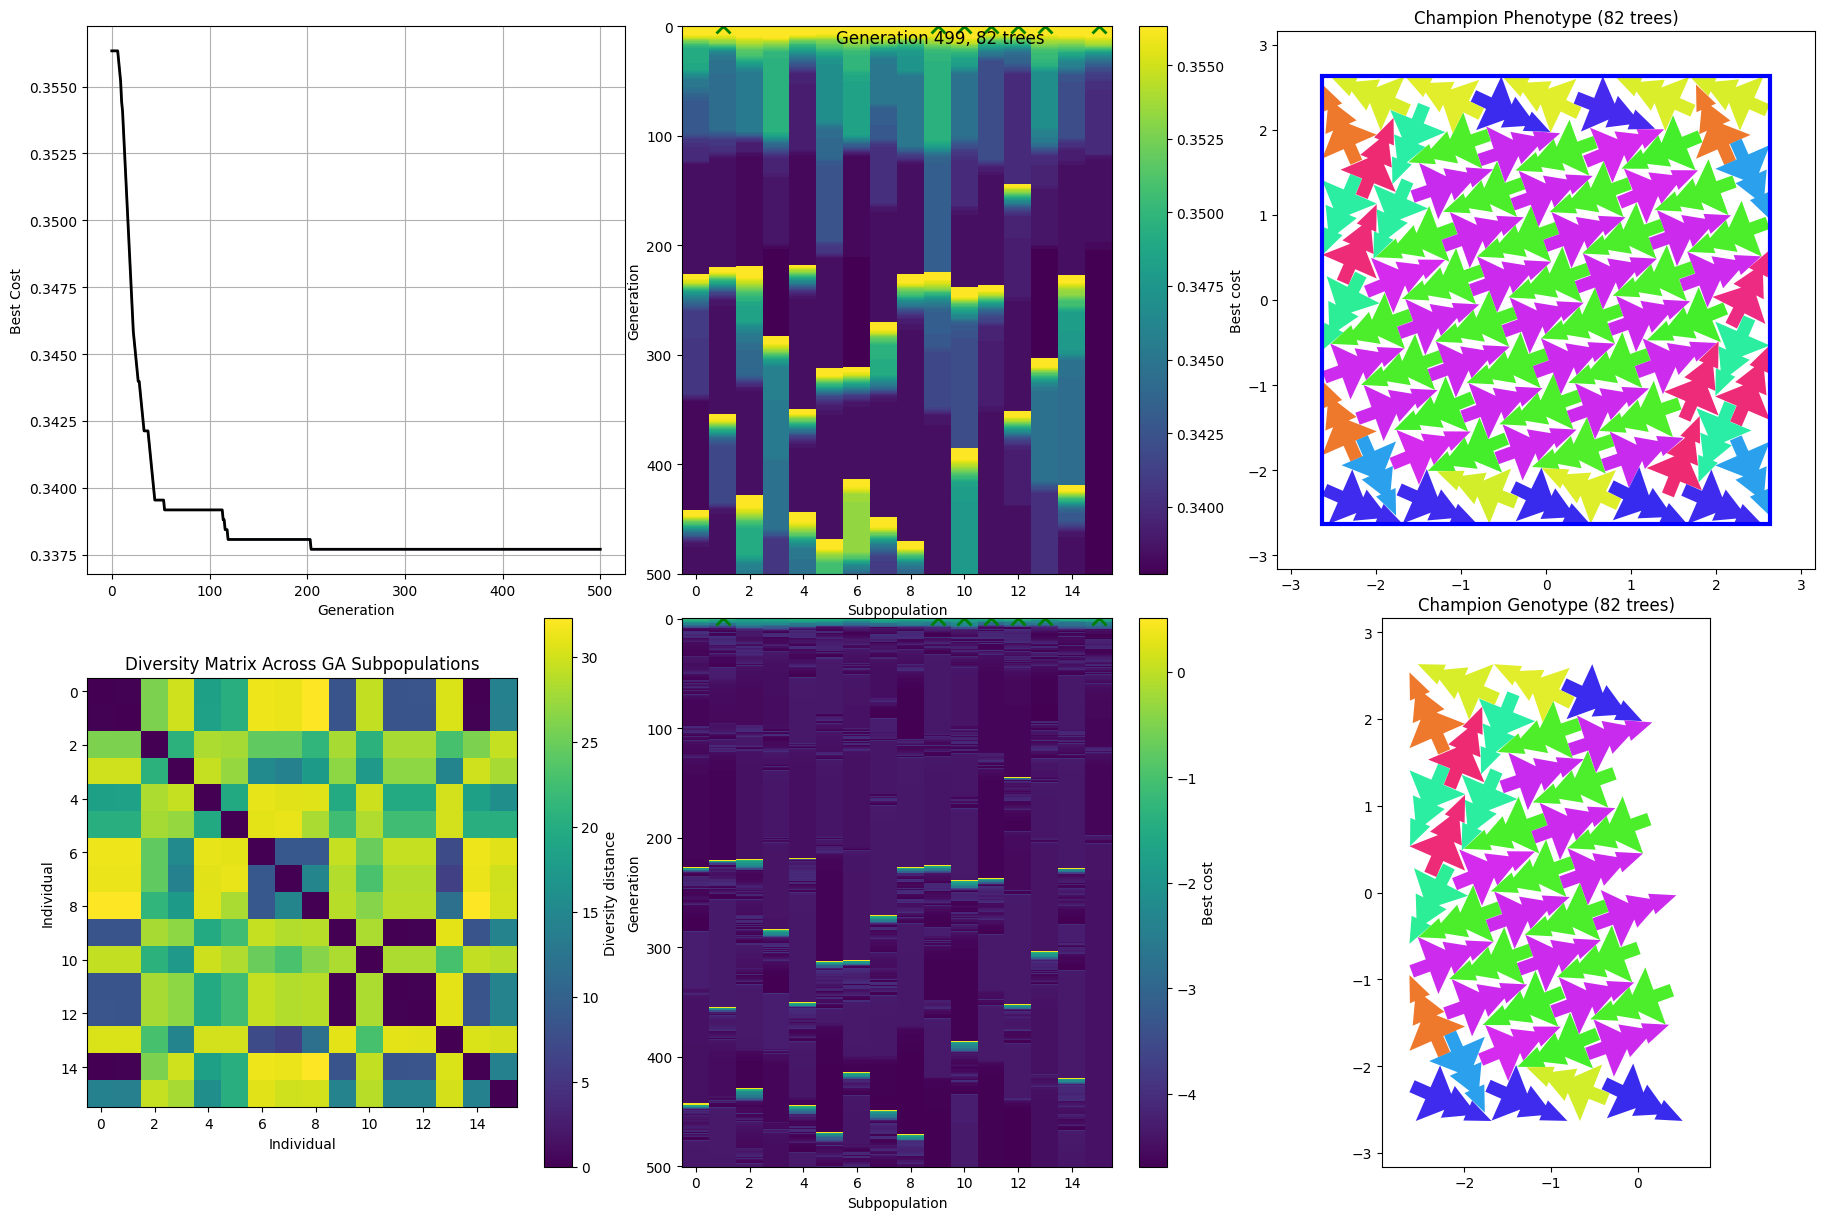


Status: Running: 1, Pending: 323, Completed: 0, Errored: 0



In [ ]:
# Initialize process manager
manager = ProcessManager(N_TREES_SEED_LIST, N_PROCESSES, base_runner, CHECKPOINT_DIR)

task_labels = [f"(N={N}, seed={seed})" for N, seed in N_TREES_SEED_LIST]
print(f"Starting controller for tasks: {task_labels}")
print(f"Max concurrent processes: {N_PROCESSES}")
print(f"Diagnostic interval: {DIAGNOSTIC_INTERVAL}s\n")

last_diagnostic_time = 0

try:
    while not manager.is_complete():
        # Update process pool
        manager.update()
        
        # Display diagnostics periodically
        current_time = time.time()
        if current_time - last_diagnostic_time >= DIAGNOSTIC_INTERVAL:
            display_diagnostics(N_TREES_SEED_LIST, CHECKPOINT_DIR, manager)
            print(f"\nStatus: {manager.status()}\n")
            last_diagnostic_time = current_time
        
        # Sleep briefly to avoid busy-waiting
        time.sleep(1)
    
    # Final update
    print("\n" + "="*60)
    print("All processes completed!")
    print("="*60 + "\n")
    display_diagnostics(N_TREES_SEED_LIST, CHECKPOINT_DIR, manager)
    
except KeyboardInterrupt:
    print("\n\nInterrupted by user!")
    print("Terminating running processes...")
    for p in manager.running.keys():
        p.terminate()
        p.join()
    print("Cleanup complete.")

## Post-Processing

In [ ]:
# Load all completed runners for analysis
completed_runners = {}

for N_trees, seed in N_TREES_SEED_LIST:
    filename = f'ga_N{N_trees}_seed{seed}'
    pickle_path = kgs.temp_dir + CHECKPOINT_DIR + filename + '.pickle'
    
    if os.path.isfile(pickle_path):
        try:
            runner = kgs.dill_load(pickle_path)
            completed_runners[(N_trees, seed)] = runner
            print(f"Loaded N={N_trees}, seed={seed}: {runner._current_generation} generations")
        except Exception as e:
            print(f"Failed to load N={N_trees}, seed={seed}: {e}")

print(f"\nTotal loaded: {len(completed_runners)} runners")

In [ ]:
# Extract best solutions
import pack_vis_sol

for (N_trees, seed), runner in completed_runners.items():
    best_costs = [[float(x) for x in s[-1].flatten()] 
                  for s in runner.ga.best_costs_per_generation]
    print(f"\nN={N_trees}, seed={seed}: Best costs = {best_costs}")
    
    # Visualize best solution
    # (Adjust based on your GA structure - GAMulti vs single GA)
    try:
        plt.figure()
        pack_vis_sol.pack_vis_sol(runner.ga.champions[-1].phenotype)
        plt.title(f"N={N_trees}, seed={seed}, Cost={runner.ga.champions[-1].fitness[0]}")
    except Exception as e:
        print(f"Could not visualize N={N_trees}, seed={seed}: {e}")